# Belief Analysis

In [2]:
%matplotlib inline
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
from ipywidgets import interact
import networkx as nx
import numpy as np
from society.agents import Complex, ConvenientlyUpsetComplex, ParanoidComplex, ConvenientlyUpsetParanoidComplex#, abeta
from society.worlds import NetWorld, LocalObsNetW
from society.eventdispatcher import AsyncEventDispatcher
from society.functions import paranoia_eq_prior, plot_network, p_stars, build_beta_lookuptable
from IPython.display import display
sns.set_palette('colorblind')

In [3]:
payoff = pd.DataFrame({'C': {'C': 1, 'D': 1.1}, 'D': {'C': 0., 'D': 0.1}})
justice = 0.3
priors = [(8, 4), (10, 2)]
paranoia_th = paranoia_eq_prior(priors[1], priors[0])
lut = build_beta_lookuptable(10, paranoia_th)
pickle.dump(lut, open('pepe.pkl', 'w'))

(10.0, 2.0)


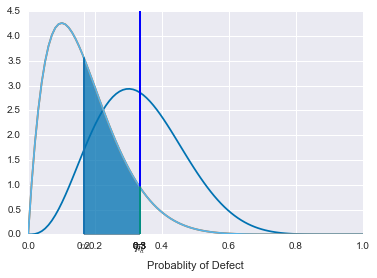

In [8]:
payoff = pd.DataFrame({'C': {'C': 1, 'D': 1.1}, 'D': {'C': 0., 'D': 0.1}})
justice = 0.3
priors = [(8, 4), (10, 2)]
paranoia_th = paranoia_eq_prior(priors[1], priors[0])
dispatcher = AsyncEventDispatcher()
#filename = 'lookuptables/' + str(paranoia_th) + str('.pkl')
#lookuptable = pickle.load(open(filename, 'r'))
#lookuptable = lut.copy()#pickle.load(open(filename, 'r'))
lookuptable={}

base = Complex(0, payoff.get_values(), dispatcher, justice=justice, prior_params=priors[0])
cu = ParanoidComplex(0, payoff.get_values(), dispatcher, justice=justice, prior_params=priors[1],
                              paranoia=paranoia_th, lookuptable=lookuptable)
mcu = ConvenientlyUpsetParanoidComplex(0, payoff.get_values(), dispatcher, justice=justice, prior_params=priors[1],
                              paranoia=paranoia_th, lookuptable=lookuptable)
mcu.observe((0, 1, 1))
other = Complex(1, payoff.get_values(), dispatcher, justice=justice, prior_params=priors[0])
#base.observe((1, 0, 0))

@interact(c=(0, 10), d=(0, 10))
def myplot(c=0, d=0):
    current_c = base.get_prior(other)[0] - priors[0][0]
    if current_c < c:
        for _ in range(c - current_c):
            base.observe((1, 0, 0))
            cu.observe((1, 0, 0))
            mcu.observe((1, 0, 0))
    elif current_c > c:
        for _ in range(current_c - c):
            base.forget((1, 0, 0))
            cu.forget((1, 0, 0))
            mcu.forget((1, 0, 0))

    current_d = base.get_prior(other)[1] - priors[0][1]
    if current_d < d:
        for _ in range(d - current_d):
            base.observe((1, 0, 1))
            cu.observe((1, 0, 1))
            mcu.observe((1, 0, 1))
    elif current_d > d:
        for _ in range(current_d - d):
            base.forget((1, 0, 1))
            cu.forget((1, 0, 1))
            mcu.forget((1, 0, 1))
            
    fig, ax = plt.subplots(1)
    base.plot_prior(other, ax=ax)
    cu.plot_prior(other, ax=ax)
    mcu.plot_prior(other, ax=ax)
    #ax.set_title('p(d) = {:.3}, p_cu(d) = {:.3}, p_mcu(d) = {:.3}'.format(base.action_probability(other)[1],
    #                                                                      cu.action_probability(other)[1],
    #                                                                      mcu.action_probability(other)[1]))
    print(mcu.get_prior(other))
    plt.show()

In [26]:
c = 9.2307692307692299
d = 2.7692307692307692
x = 0.23076923076923075

print(lookuptable['cdf'][c][d])
print(lookuptable['cdf'][9][3])
b = abeta((c, d))
print(b.cdf(x))

b = abeta((d, c))
print(b.cdf(x))

defaultdict(<function rec_ddict at 0x7f4c504d1c08>, {0.23076923076923075: 0.76006611828342696})
defaultdict(<function rec_ddict at 0x7f4c504d1c08>, {0.25: 0.54479908943176281})
0.549575806428
3.49709743901e-05


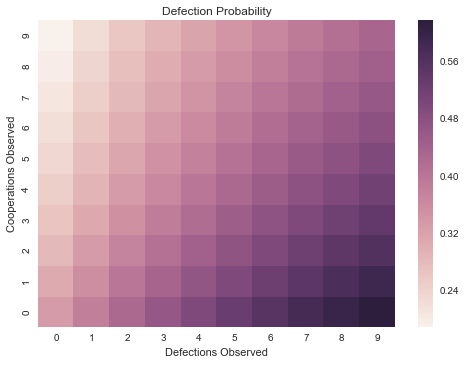

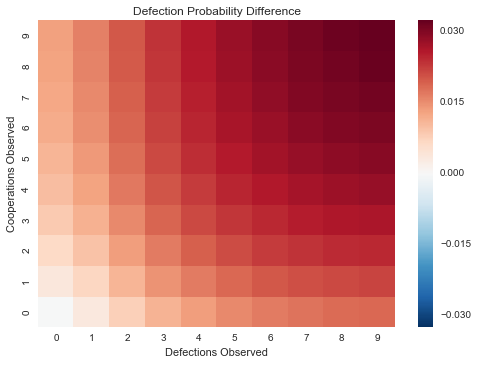

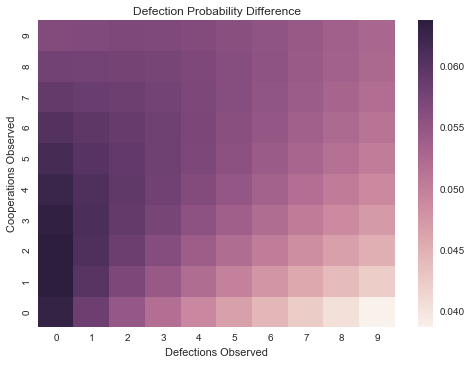

In [3]:
payoff = pd.DataFrame({'C': {'C': 1, 'D': 1.1}, 'D': {'C': 0., 'D': 0.1}})
justice = 0.3
priors = [(8, 4), (10, 2)]
paranoia_th = paranoia_eq_prior(priors[1], priors[0])
dispatcher = AsyncEventDispatcher()
filename = 'lookuptables/' + str(paranoia_th) + str('.pkl')
lookuptable = pickle.load(open(filename, 'r'))


base = Complex(0, payoff.get_values(), dispatcher, justice=justice, prior_params=priors[0])
cu = ParanoidComplex(0, payoff.get_values(), dispatcher, justice=justice, prior_params=priors[1],
                              paranoia=paranoia_th, lookuptable=lookuptable)
mcu = ConvenientlyUpsetParanoidComplex(0, payoff.get_values(), dispatcher, justice=justice, prior_params=priors[1],
                              paranoia=paranoia_th, lookuptable=lookuptable)
other = Complex(1, payoff.get_values(), dispatcher, justice=justice, prior_params=priors[0])

mcu.observe((0, 1, 1))
baseM = pd.DataFrame(np.zeros((10, 10)), index=range(9, -1, -1), columns=range(10))
cuM = pd.DataFrame(np.zeros((10, 10)), index=range(9, -1, -1), columns=range(10))
mcuM = pd.DataFrame(np.zeros((10, 10)), index=range(9, -1, -1), columns=range(10))
for c in range(10):
    for d in range(10):
        baseM.loc[c, d] = base.action_probability(other)[1]
        cuM.loc[c, d] = cu.action_probability(other)[1]
        mcuM.loc[c, d] = mcu.action_probability(other)[1]
        base.observe((1, 0, 1))
        cu.observe((1, 0, 1))
        mcu.observe((1, 0, 1))
    base.observe((1, 0, 0))
    cu.observe((1, 0, 0))
    mcu.observe((1, 0, 0))
    for d in range(10):
        base.forget((1, 0, 1))
        cu.forget((1, 0, 1))
        mcu.forget((1, 0, 1))


plt.figure(1)
ax = sns.heatmap(baseM)
ax.set_xlabel('Defections Observed')
ax.set_ylabel('Cooperations Observed')
ax.set_title('Defection Probability')
#ax.plot([0.25, 5.5], [10, -0.5])


plt.figure(2)
ax = sns.heatmap(cuM-baseM)
ax.set_title('Defection Probability Difference')
ax.set_xlabel('Defections Observed')
ax.set_ylabel('Cooperations Observed')

plt.figure(3)
ax = sns.heatmap(mcuM-baseM)
ax.set_title('Defection Probability Difference')
ax.set_xlabel('Defections Observed')
ax.set_ylabel('Cooperations Observed')


plt.show()

# Bootstrap Percolation Correspondance

In [208]:
%matplotlib inline
from vector_society.functions import build_beta_lookuptable, paranoia_eq_prior
from percolation import get_erdosh
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import btdtr, btdtri
import pandas as pd
import seaborn as sns
from scipy.optimize import brentq

def build_beta_lookuptable_original(n, paranoia, cog_dis, max_k):
    """It builds a manipulated_mean lookuptable in order to improve performance.

    It builds a manipulated_mean lookuptable in order to improve performance.
    n is the memory length of the agents and max_k is the maximun degree fo the
    network.

    It returns a matrix. Its rows are the defections of othres and its columns
    are its own defections.
    """
    manipulated_mean = np.nan * np.ones((n + 1, max_k * (n + 1), max_k + 1))
    a = np.arange(0, n + 1, dtype='float')
    b = n - a
    for own_prior in xrange(max_k * (n + 1)):
        for own_k in xrange(max_k + 1):
            a2 = a.copy()
            b2 = b.copy()
            if own_k != 0:
                a2 += cog_dis * own_prior / own_k
            new_events = a2 + b2
            with np.errstate(invalid='ignore'):
                a2 = a2 * n / new_events
                b2 = b2 * n / new_events
            mean = a2 / (a2 + b2)
            proba = btdtr(a2, b2, mean)
            proba += paranoia
            out = btdtri(a2, b2, proba)
            manipulated_mean[:, own_prior, own_k] = out
    return manipulated_mean

def theta_hat(paranoia, cogdis, fraction):
    a = 1
    b = n - a
    own_k = 100
    own_prior = np.floor(12 * fraction * own_k)
    a2 = a
    b2 = b
    a2 += cog_dis * own_prior / own_k
    new_events = a2 + b2
    with np.errstate(invalid='ignore'):
        a2 = a2 * n / new_events
        b2 = b2 * n / new_events
    mean = a2 / (a2 + b2)
    proba = btdtr(a2, b2, mean)
    proba += paranoia
    out = btdtri(a2, b2, proba)
    return out

def theta_hat_s(paranoia, cogdis, fraction):
    a = 1
    b = n - a
    own_k = 100
    own_prior = np.floor(12 * fraction * own_k)
    a2 = a
    b2 = b
    a2 += cog_dis * own_prior / own_k
    b2 += cog_dis * (n * own_k - own_prior) / own_k
    new_events = a2 + b2
    with np.errstate(invalid='ignore'):
        a2 = a2 * n / new_events
        b2 = b2 * n / new_events
    mean = a2 / (a2 + b2)
    proba = btdtr(a2, b2, mean)
    proba += paranoia
    out = btdtri(a2, b2, proba)
    return out

In [157]:
network_seed = 1
param = 4.0
memory = 12
priorC0 = 8
priorC = 10
expected_nodes = 10**5
prior0 = (priorC0, memory - priorC0)
cog_dis = 0.75
G, adj = get_erdosh(network_seed, expected_nodes, param / expected_nodes)
number_of_nodes = G.number_of_nodes()
justice = 0.3
payoff = np.array([[1, 0], [1.1, 0.1]])
payoff += np.eye(2) * justice
tmax = 2000
prior = np.array((priorC, memory - priorC)).astype(int)
paranoia = paranoia_eq_prior(prior, prior0)
print(paranoia)
max_k = max(G.degree().values())
del G
beta_lut = build_beta_lookuptable_original(memory, paranoia, cog_dis, max_k)
for i, val in enumerate(beta_lut[1, 12, 1:]):
    if val < 1./3:
        break
        
i+1

0.355534924738


8

(13, 195, 16)
[ 0.63105124  0.49713128  0.43193629  0.39368335  0.36872684  0.35128929
  0.33850468  0.32879048  0.32120241  0.31514288  0.31021585  0.30614886
  0.30274861  0.2998744   0.29742152]
0.333333333333
(0.38461538461538464, 0.38333333333333336, 0.13333333333333333)


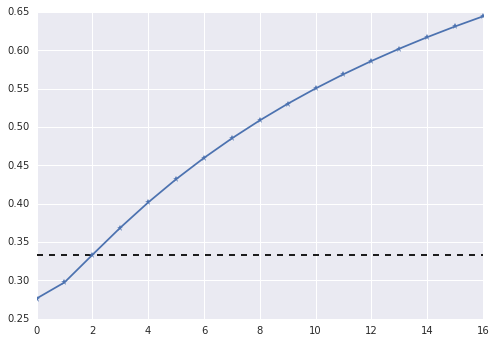

In [163]:
sh = beta_lut.shape
print(sh)
print(beta_lut[1, 12, 1:])
plt.plot(beta_lut[1, ::12, 15], '*-')
plt.hlines(1./3, 0, 16, linestyles='dashed')
print(beta_lut[1,24, 15])
60/12
phi1 = 5./13
phi2 = 69./12./15
print(phi1, phi2, 24./12./15)

In [211]:
df = pd.DataFrame(index=[0, 0.25, 0.5, 0.75], columns=[8, 9, 10, 11])
for cog_dis in [0, 0.25, 0.5, 0.75]:
    for priorC in [8, 9, 10, 11]:
        prior = np.array((priorC, memory - priorC)).astype(int)
        paranoia = paranoia_eq_prior(prior, prior0)
        #print(cog_dis,priorC, theta_hat(paranoia, cog_dis, 0), theta_hat(paranoia, cog_dis, 1))

        if theta_hat(paranoia, cog_dis, 1) < 1./3:
            o = 1
        elif theta_hat(paranoia, cog_dis, 0) > 1./3:
            o = 1
        else:
            o = brentq(lambda x, paranoia, cog_dis: 1./3 - theta_hat(paranoia, cog_dis, x), 0, 1, args=(paranoia, cog_dis))

        df.loc[cog_dis, priorC] = o
df

8         9         10         11
0.00         1         1         1          1
0.25         1  0.889167  0.400833   0.278333
0.50  0.750833     0.445  0.200833   0.139167
0.75  0.500833  0.296667  0.134167  0.0933333

In [212]:
df = pd.DataFrame(index=[0, 0.25, 0.5, 0.75], columns=[8, 9, 10, 11])
for cog_dis in [0, 0.25, 0.5, 0.75]:
    for priorC in [8, 9, 10, 11]:
        prior = np.array((priorC, memory - priorC)).astype(int)
        paranoia = paranoia_eq_prior(prior, prior0)
        #print(cog_dis, priorC, theta_hat_s(paranoia, cog_dis, 0), theta_hat_s(paranoia, cog_dis, 1))

        if theta_hat_s(paranoia, cog_dis, 1) > 1./3:
            if theta_hat_s(paranoia, cog_dis, 0) > 1./3:
                o = 0
            else:
                o = brentq(lambda x, paranoia, cog_dis: 1./3 - theta_hat_s(paranoia, cog_dis, x), 0, 1, args=(paranoia, cog_dis))
        else:
            o = 1
        df.loc[cog_dis, priorC] = o
df

8         9         10 11
0.00         1         1         1  1
0.25         1    0.9175  0.500833  0
0.50  0.834167  0.584167         0  0
0.75    0.6675    0.4725         0  0